In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import io
import scipy.io.wavfile as wav
from scipy.linalg import toeplitz
%matplotlib inline
plt.rcParams['figure.figsize']=(6,4)

# LINEAR PREDICTIVE CODING

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LPC-y-la-envolvente-del-espectro" data-toc-modified-id="LPC-y-la-envolvente-del-espectro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LPC y la envolvente del espectro</a></span><ul class="toc-item"><li><span><a href="#LPC-para-un-frame-de-audio" data-toc-modified-id="LPC-para-un-frame-de-audio-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>LPC para un frame de audio</a></span><ul class="toc-item"><li><span><a href="#Espectro" data-toc-modified-id="Espectro-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Espectro</a></span></li><li><span><a href="#Señal-predicha" data-toc-modified-id="Señal-predicha-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Señal predicha</a></span></li><li><span><a href="#Error" data-toc-modified-id="Error-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Error</a></span></li></ul></li><li><span><a href="#LPC-para-fantasia.wav" data-toc-modified-id="LPC-para-fantasia.wav-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>LPC para fantasia.wav</a></span><ul class="toc-item"><li><span><a href="#Espectro" data-toc-modified-id="Espectro-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Espectro</a></span></li><li><span><a href="#Formantes-vocales" data-toc-modified-id="Formantes-vocales-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Formantes vocales</a></span></li></ul></li></ul></li><li><span><a href="#LPC-aplicado-a-codificación" data-toc-modified-id="LPC-aplicado-a-codificación-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LPC aplicado a codificación</a></span><ul class="toc-item"><li><span><a href="#Reconstrucción-de-la-señal" data-toc-modified-id="Reconstrucción-de-la-señal-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reconstrucción de la señal</a></span></li><li><span><a href="#Reconstrucción-de-la-señal-con-error-cuantizado" data-toc-modified-id="Reconstrucción-de-la-señal-con-error-cuantizado-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Reconstrucción de la señal con error cuantizado</a></span></li><li><span><a href="#Comparación-costo/calidad" data-toc-modified-id="Comparación-costo/calidad-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Comparación costo/calidad</a></span><ul class="toc-item"><li><span><a href="#Calidad" data-toc-modified-id="Calidad-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Calidad</a></span></li><li><span><a href="#Costo" data-toc-modified-id="Costo-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Costo</a></span></li></ul></li></ul></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></div>

## LPC y la envolvente del espectro
Antes de utilizar el algoritmo para codificar la señal de audio completa, se analizaran los resultados sobre un único frame.
### LPC para un frame de audio
Se utilizará una ventana de 25 ms a partir de la muestra numero 14000 (875 ms). Se sabe que al realizar la codificación correctamente y calcular el espectro que del filtro caracterizado por los coeficientes obtenidos, el mismo muestra un primer pico a los 725 Hz.
#### Espectro

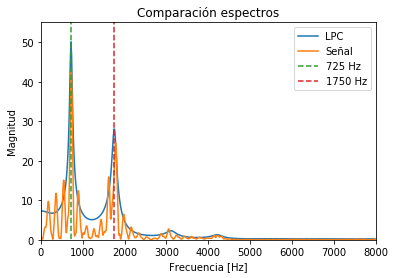

In [4]:
# Carga de los valores numéricos de la señal
(Fs,fantasia) = wav.read('fantasia.wav')
fantasia = fantasia.astype(float)/32767

#---------------------------------#
# Cálculo de los coeficientes LPC #
#---------------------------------#
M = 20         # cantidad de coeficientes del filtro
dur = 0.025    # duración de la ventana en segundos
ventana = fantasia[14000:14000+np.int(Fs*dur)]
# Estimación de la correlación
acorr = signal.correlate(ventana, ventana,'full','direct')
acorr = acorr[np.int(Fs*dur)-1:np.int(Fs*dur)+M-1]
# Resolución de las ecuaciones normales
A = toeplitz(acorr[:-1],acorr[:-1])
B = np.array([acorr[1:]])
coef = np.dot(B,np.linalg.inv(A))

#-------------------------------------------------#
# Cálculo de la respuesta en frecuencia + gráfico #
#-------------------------------------------------#
# Espectro del filtro predictivo
b = np.array([1])
a = np.hstack((1,-coef.reshape(M-1)))
w,espectro = signal.freqz(b,a)
# Espectro de la señal
s = ventana * np.hamming(ventana.size)
s = np.hstack((s,np.zeros(ventana.size*7)))
S = np.abs(np.fft.fft(s))*np.pi
ws = np.linspace(0,Fs,s.size)
# Gráfico
fig,ax1 = plt.subplots()
ax1.plot(w*Fs/2/np.pi,np.abs(espectro))
ax1.plot(ws,S)
ax1.plot([725,725],[60,-1],'--')
ax1.plot([1750,1750],[60,-1],'--')
ax1.set(ylim=[0,55], xlim=[0,Fs/2],
        ylabel='Magnitud',xlabel='Frecuencia [Hz]',
        title='Comparación espectros')
ax1.legend(('LPC','Señal','725 Hz','1750 Hz'))

Se puede ver que el primer pico del filtro coincide con la frecuencia esperada. Se cumple que las formantes de este filtro y la señal se corresponden con el sonido del fonema vocálico de la "A".
#### Señal predicha

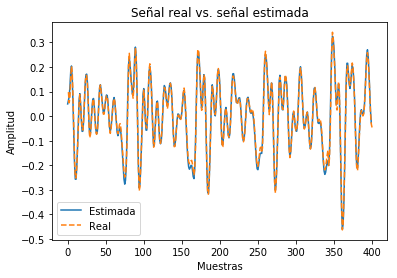

In [46]:
#--------------------------#
# Señal estimada + gráfico #
#--------------------------#
# Señal
s_est=signal.lfilter(b,coef[0,:],ventana)

#Gráfico
fig,ax1 = plt.subplots()
ax1.set(title='Señal real vs. señal estimada', xlabel='Muestras', ylabel='Amplitud')
ax1.plot(s_est)
ax1.plot(np.arange(ventana.size)+1,ventana,'--')
ax1.legend(('Estimada','Real'))

#### Error

Para calcular el error se utilizó la función lfilter de la siguiente forma:

$ e(n) = s(n) - \hat{s}(n)$

$ e(n) = s(n) - a_1\ s(n-1) - a_2\ s(n-2)\, -\, ... -\, a_N\ s(n-N)$

Lo cual equivale a un filtro FIR de con los coeficientes obtenidos más arriba

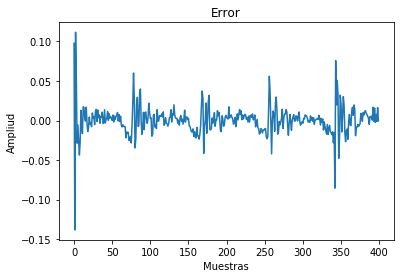

In [31]:
#-----------------------------#
# Cálculo del error + gráfico #
#-----------------------------#
# Cálculo del error
error = signal.lfilter(a,b,ventana)
# Gráfico
fig,ax1=plt.subplots()
ax1.set(ylabel='Ampliud',xlabel='Muestras',title='Error')
ax1.plot(error)

Se puede ver que la amplitud del error se corresponde con lo esperado. Las amplitudes mayores a 0.7 obtenidas al principio son producto de el relleno de ceros que hizo la función para calcular esos puntos.
### LPC para fantasia.wav
#### Espectro

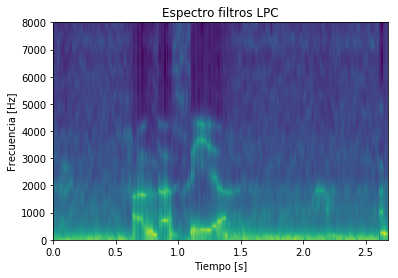

In [5]:
#-------------------------------------------------#
# Loop de codificación + espectrograma filtro LPC #
#-------------------------------------------------#
# Parámetros
M = 20        # cantidad de coeficientes del filtro
dur = .025    # duracion de la ventana en segundos
paso = .01    # desplazamiendo entre ventanas

# Inicialización de variables (primera iteración ciclo)
b = np.array([1])
ventana = fantasia[:np.int(Fs*dur)]
acorr = signal.correlate(ventana,ventana,'full','direct')
acorr = acorr[np.int(Fs*dur)-1:np.int(Fs*dur)+M-1]
A = toeplitz(acorr[:-1],acorr[:-1])
B = np.array([acorr[1:]])
coef = np.dot(B,np.linalg.inv(A))
a = np.hstack((1,-coef.reshape(M-1)))
w,espectro = signal.freqz(b,a)
LPC_coef = np.array([coef]).T # los coeficientes se guardan en columnas
LPC_spec = np.array([espectro]).T
# Ciclo principal
for i in np.arange(np.int(Fs*paso),fantasia.size,np.int(Fs*paso)):
    ventana = fantasia[i:i+np.int(Fs*dur)]
    if not(ventana.size==np.int(Fs*dur)):
        break
    acorr = signal.correlate(ventana,ventana,'full','direct')
    acorr = acorr[np.int(Fs*dur)-1:np.int(Fs*dur)+M-1]
    A = toeplitz(acorr[:-1],acorr[:-1])
    B = np.array([acorr[1:]])
    coef = np.dot(B,np.linalg.inv(A))
    a=np.hstack((1,-coef.reshape(M-1)))
    w,espectro = signal.freqz(b,a)
    LPC_coef = np.hstack((LPC_coef,np.array([coef]).T))
    LPC_spec = np.hstack((LPC_spec,np.array([espectro]).T))
    
# Espectrograma
t=np.linspace(0,.01*LPC_spec.shape[1],LPC_spec.shape[1])
f=np.linspace(0,Fs/2,512)
fig,ax1=plt.subplots()
ax1.set(title='Espectro filtros LPC', xlabel='Tiempo [s]', ylabel='Frecuencia [Hz]')
ax1.pcolormesh(t,f,20*np.log10(np.abs(LPC_spec)))

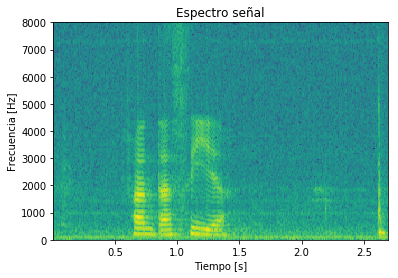

In [71]:
fig,ax1=plt.subplots()
ax1.set(title='Espectro señal', xlabel='Tiempo [s]', ylabel='Frecuencia [Hz]')
asd=ax1.specgram(fantasia,NFFT=int(Fs*.018),Fs=Fs,window=np.hamming(int(Fs*.018)),noverlap=int(Fs*0.009),pad_to=512)

Puede verse que el espectro de los filtros LPC da una idea de las formantes de cada fonema.
#### Formantes vocales

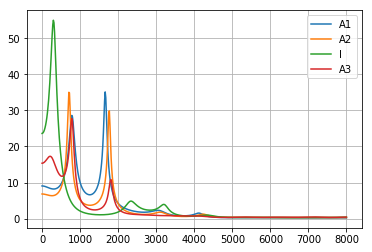

In [44]:
#-------------------------#
# Vocales y sus formantes #
#-------------------------#
# Tiempos en los cuales ocurre cada vocal
fonema_A1_t = 0.700
fonema_A2_t = 0.875
fonema_I_t = 1.100
fonema_A3_t = 1.350

# Obtención del indice del frame LPC que se corresponde a cada vocal
fonema_A1_f = fonema_A1_t/paso
fonema_A2_f = fonema_A2_t/paso
fonema_I_f = fonema_I_t/paso
fonema_A3_f = fonema_A3_t/paso
# Gráfico
w=np.linspace(0,8000,512)
fig,ax1=plt.subplots()
ax1.plot(w,np.abs(LPC_spec[:,np.int(fonema_A1_f)]))
ax1.plot(w,np.abs(LPC_spec[:,np.int(fonema_A2_f)]))
ax1.plot(w,np.abs(LPC_spec[:,np.int(fonema_I_f)]))
ax1.plot(w,np.abs(LPC_spec[:,np.int(fonema_A3_f)]))
ax1.legend(('A1','A2','I','A3'))
ax1.grid(1,which='both')

Se utilizó para el fonema A2, la misma muestra que en el analisis de un [único frame del audio](#Espectro). Ya se sabía que este pertenecía a una A. Se puede ver que A1 y A3, tienen picos en las mismas frecuencias que A2. Sin embargo A3, proveniente de un diptongo todavía muestra vestigios de la I que lo precedía.

Para el fonema I, se ven picos en aproximadamente 350 Hz y 2300 Hz. Los cuales se condicen con los primeros dos formantes de la I
## LPC aplicado a codificación
### Reconstrucción de la señal

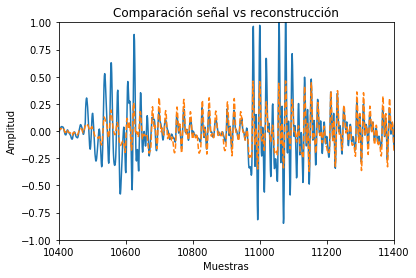

In [70]:
#----------------------------#
# Reconstrucción de la señal #
#----------------------------#
# Error, iteración inicial
error = signal.lfilter(np.hstack((1,-LPC_coef[:,0,0])),b,fantasia[:np.int(Fs*dur)])
# Error, loop principal
for i in np.arange(np.int(Fs*paso)-M,np.int(fantasia.size-Fs*dur),np.int(Fs*paso)):
    LPC_coef_i=np.int(i/(paso*Fs))
    er=signal.lfilter(np.hstack((1,-LPC_coef[:,LPC_coef_i,0])),b,fantasia[i:i+np.int(Fs*dur)])
    error=np.hstack((error,er[-np.int(Fs*paso):]))

# Reconstruccion, iteración inicial
fantasia_sint=signal.lfilter(b,np.hstack((1,-LPC_coef[:,0,0])),error[:np.int(Fs*dur)])
# Reconstrucción, loop principal
for i in np.arange(np.int(Fs*paso),fantasia.size-np.int(Fs*dur),np.int(Fs*paso)):
    LPC_coef_i=np.int(i/Fs/paso)
    (sint,z)=signal.lfilter(b,np.hstack((1,-LPC_coef[:,LPC_coef_i,0])),error[i:i+np.int(Fs*dur)],zi=fantasia_sint[-M+1:])
    fantasia_sint=np.hstack((fantasia_sint,sint[-np.int(Fs*paso):]))
# Exportación a audio
audio=fantasia_sint*32767/np.max(np.abs(fantasia_sint))
wav.write('fantasia_sint.wav',Fs,audio.astype('int16'))

# Gráfico
fig,ax1=plt.subplots()
ax1.set(ylim=[-1,1],xlim=[10400,11400],ylabel='Amplitud',xlabel='Muestras',
        title='Comparación señal vs reconstrucción')
ax1.plot(fantasia_sint)
ax1.plot(np.arange(fantasia.size)+20,fantasia,'--') # desplazo la señal por el retardo del filtro

### Reconstrucción de la señal con error cuantizado

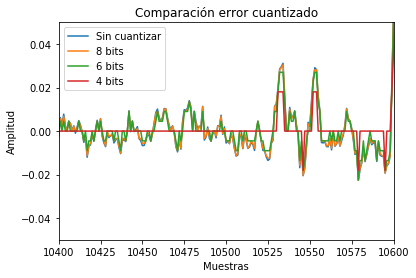

In [71]:
#------------------------#
# Cuantización del error #
#------------------------#
# Usando el error calculado anteriormente lo cuantizo a 8 bits
error_rd=np.max(np.abs(error)) # para el ruido voy a usar un rango dinamico de +-max(|error|)
error8=error/error_rd*128
error8=error8.astype('int8')   # acá cuantice el error
error6=error8/4
error6=error6.astype('int8')
error4=error8/16
error4=error4.astype('int8')
error8=error8.astype('float')*error_rd/128 # deshago la transformación en int
error6=error6.astype('float')*error_rd/32
error4=error4.astype('float')*error_rd/8

#-----------------------------------------#
# Reconstrucción de la señal 8, 6 ,4 bits #
#-----------------------------------------#
# Para 8 bits
# Reconstruccion, iteración inicial
fantasia_sint8=signal.lfilter(b,np.hstack((1,-LPC_coef[:,0,0])),error8[:np.int(Fs*dur)])
# Reconstrucción, loop principal
for i in np.arange(np.int(Fs*paso),fantasia.size-np.int(Fs*dur),np.int(Fs*paso)):
    LPC_coef_i=np.int(i/Fs/paso)
    (sint,z)=signal.lfilter(b,np.hstack((1,-LPC_coef[:,LPC_coef_i,0])),error8[i:i+np.int(Fs*dur)],zi=fantasia_sint8[-M+1:])
    fantasia_sint8=np.hstack((fantasia_sint8,sint[-np.int(Fs*paso):]))

# Para 6 bits
# Reconstruccion, iteración inicial
fantasia_sint6=signal.lfilter(b,np.hstack((1,-LPC_coef[:,0,0])),error6[:np.int(Fs*dur)])
# Reconstrucción, loop principal
for i in np.arange(np.int(Fs*paso),fantasia.size-np.int(Fs*dur),np.int(Fs*paso)):
    LPC_coef_i=np.int(i/Fs/paso)
    (sint,z)=signal.lfilter(b,np.hstack((1,-LPC_coef[:,LPC_coef_i,0])),error6[i:i+np.int(Fs*dur)],zi=fantasia_sint6[-M+1:])
    fantasia_sint6=np.hstack((fantasia_sint6,sint[-np.int(Fs*paso):]))

# Para 6 bits
# Reconstruccion, iteración inicial
fantasia_sint4=signal.lfilter(b,np.hstack((1,-LPC_coef[:,0,0])),error4[:np.int(Fs*dur)])
# Reconstrucción, loop principal
for i in np.arange(np.int(Fs*paso),fantasia.size-np.int(Fs*dur),np.int(Fs*paso)):
    LPC_coef_i=np.int(i/Fs/paso)
    (sint,z)=signal.lfilter(b,np.hstack((1,-LPC_coef[:,LPC_coef_i,0])),error4[i:i+np.int(Fs*dur)],zi=fantasia_sint4[-M+1:])
    fantasia_sint4=np.hstack((fantasia_sint4,sint[-np.int(Fs*paso):]))

# Exportación de los audios
audio=fantasia_sint8*32000/np.max(np.abs(fantasia_sint8))
wav.write('fantasia_sint8.wav',Fs,audio.astype('int16'))
audio=fantasia_sint6*32000/np.max(np.abs(fantasia_sint6))
wav.write('fantasia_sint6.wav',Fs,audio.astype('int16'))
audio=fantasia_sint4*32000/np.max(np.abs(fantasia_sint4))
wav.write('fantasia_sint4.wav',Fs,audio.astype('int16'))

# Gráfico
fig,ax1=plt.subplots()
ax1.set(ylim=[-.05,.05],xlim=[10400,10600],ylabel='Amplitud',xlabel='Muestras',
        title='Comparación error cuantizado')
ax1.plot(error)
ax1.plot(error8)
ax1.plot(error6)
ax1.plot(error4)
ax1.legend(('Sin cuantizar','8 bits','6 bits','4 bits'))

En el gráfico anterior no puede verse la señal de error sin cuantizar, esto quiere decir, que con 8 bits se sigue la señal de forma que el error de cuantización no es apreciable en el gráfico. En los otros casos se aprecia una variación en la señal original siendo esta mas marcada al utilizar solo 4 bits.
### Comparación costo/calidad
#### Calidad
A continuación se reprodujeron las señales generadas. Si bien puede percibirse un poco mas de ruido en la señal de 4 bits. El mensaje, la voz contenida en el archivo de audio, se reconstruyó sin alteraciones significativas.

In [83]:
%%html
<string> Audio sin cuantizar<br> </string>
<audio controls preload='none'>
    <source src="fantasia_sint.wav" type="audio/wav">
</audio>

In [84]:
%%html
<string> Audio con error cuantizado a 8 bits <br> </string>
<audio controls preload='none'>
    <source src="fantasia_sint8.wav" type="audio/wav">
</audio>

In [85]:
%%html
<string> Audio con error cuantizado a 6 bits <br> </string>
<audio controls preload='none'>
    <source src="fantasia_sint6.wav" type="audio/wav">
</audio>

In [86]:
%%html
<string> Audio con error cuantizado a 4 bits <br> </string>
<audio controls preload='none'>
    <source src="fantasia_sint4.wav" type="audio/wav">
</audio>

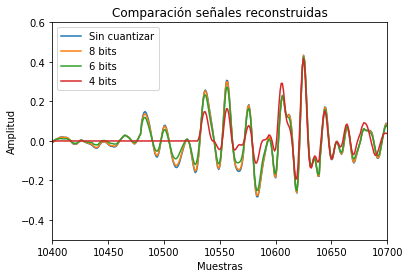

In [91]:
#--------------------------------#
# Gráfico comparativo de señales #
#--------------------------------#
fig,ax1=plt.subplots()
ax1.set(ylim=[-.5,.6],xlim=[10400,10700],ylabel='Amplitud',xlabel='Muestras',
        title='Comparación señales reconstruidas')
ax1.plot(fantasia_sint/np.max(np.abs(fantasia_sint)))
ax1.plot(fantasia_sint8/np.max(np.abs(fantasia_sint8)))
ax1.plot(fantasia_sint6/np.max(np.abs(fantasia_sint6)))
ax1.plot(fantasia_sint4/np.max(np.abs(fantasia_sint4)))
ax1.legend(('Sin cuantizar','8 bits','6 bits','4 bits'))

#### Costo
El costo de enviar el audio fantasia.wav requiere un envió de un paquete de 16 bits a una frecuencia de 16 kHz. Lo cual hace necesaria una tasa de transferencia en bits de 256 kbps.

Por otro lado, LPC requiere 20 coeficientes de 32 bits cada 10 ms y la señal de error de cantidad de bits k y 16 kHz de frecuencia. Entonces:

$ r = \dfrac{20 \cdot 32\mbox{ b}}{0.01\mbox{ s}} + k \cdot 16\mbox{ kHz} = 64\mbox{ kbps} + k \cdot 16\mbox{ kHz} $

Con esta fórmula se construyó la siguiente tabla comparativa:

| |s/cod|LPC8|LPC6|LPC4|
|---|-----|----|----|----|
|**Rate**|256 kbps|192 kbps|160 kbps|128kbps|

Cabe destacar, que si se usan coeficientes de filtro con menor cantidad de bits las tasas pueden reducirse aún más.

## Conclusiones
Utilizando los conocimientos sobre el funcionamiento del tracto vocal y procesos estocásticos pudo codificarse el habla de modo que se redujo hasta un 50% la tasa de bits necesaria para la transmición de la misma. Esta misma codificación ademas, permite obtener las frecuencias formantes de los fonemas con lo que puede ser utilizada para identificarlos.